In [61]:
%load_ext autoreload
%autoreload 2
# pull in new changes to python modules without having to restart notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control

from jsbsim_utils import Logger, trim, simulate, linearize, rootlocus, clean_tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u) \approx f(x_0, u_0) + A(x-x0) + B(u - u0)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

## Relative Stability

* Measure of relative stability. Phase margin of 90 degrees.


* sin(2*pi*f*t), where f = 10 Hz, what does a phase of 90 degrees mean -> 0.025 delay in your feedback will destabilize your system

* gain margin of 2 on pitch control -> if elevator genertes twice your predicted force, you destabilize your aircraft

# Ground Trim

In [62]:
op_ground, props = trim(
    aircraft='BR1-mk3',
    ic={
        'ic/vt-fps': 0,
        'ic/psi-true-deg': 280,
        'ap/gear-enable': 1,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 3],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    ftol=1e-3,
)
op_ground

 final_simplex: (array([[0.01273337, 4.76162589],
       [0.01274668, 4.76155533],
       [0.01275868, 4.76166367]]), array([1.85015203e-05, 2.09091450e-05, 5.63353067e-05]))
           fun: 1.8501520282241987e-05
       message: 'Optimization terminated successfully.'
          nfev: 106
           nit: 58
        status: 0
       success: True
             x: array([0.01273337, 4.76162589])


{'ic/vt-fps': 0,
 'ic/psi-true-deg': 280,
 'ap/gear-enable': 1,
 'fcs/left-brake-cmd-norm': 1,
 'fcs/right-brake-cmd-norm': 1,
 'fcs/center-brake-cmd-norm': 1,
 'ic/theta-rad': 0.012733366894314072,
 'ic/h-agl-ft': 4.761625892766318}

In [63]:
log_ground = simulate(
    aircraft='BR1-mk3',
    op_0=op_ground,
    tf=5,
    realtime=False)

## Hover Trim

In [64]:
op_hover, props = trim(
    aircraft='BR1-mk3',
    ic={
        'ic/h-sl-ft': 850,
        'ic/vt-fps': 0,
        'ic/psi-true-deg': 280,
        'ap/gear-enable': 1,
    },
    eq_constraints = [
        lambda fdm: fdm['accelerations/udot-ft_sec2'],
        #lambda fdm: fdm['accelerations/vdot-ft_sec2'],
        lambda fdm: fdm['accelerations/wdot-ft_sec2'],
        lambda fdm: fdm['accelerations/pdot-rad_sec2'],
        lambda fdm: fdm['accelerations/qdot-rad_sec2'],
        lambda fdm: fdm['accelerations/rdot-rad_sec2'],
    ],
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/aileron-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
        'propulsion/engine[1]/pitch-angle-rad',
    ],
    x0=[0.8, 0.08, 0, np.deg2rad(75), np.deg2rad(75)],
    cost= lambda fdm: fdm['fcs/throttle-cmd-norm'],
    verbose=True,
    method='SLSQP',
    bounds=[[0, 1], [-1, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)],  [np.deg2rad(0), np.deg2rad(120)]],
)
op_hover

     fun: 0.7951333737934487
     jac: array([1., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 7.95133374e-01,  4.10033541e-01, -1.02561626e-09,  1.57079633e+00,
        1.57079633e+00])
constraint eq -6.518825410029017e-12
constraint eq 7.73070496506989e-12
constraint eq 8.980057671654592e-16
constraint eq 4.5158552574381105e-13
constraint eq 3.8276807966185596e-17


{'ic/h-sl-ft': 850,
 'ic/vt-fps': 0,
 'ic/psi-true-deg': 280,
 'ap/gear-enable': 1,
 'fcs/throttle-cmd-norm': 0.7951333737934487,
 'fcs/elevator-cmd-norm': 0.41003354095200173,
 'fcs/aileron-cmd-norm': -1.0256162574532907e-09,
 'propulsion/engine/pitch-angle-rad': 1.5707963334038388,
 'propulsion/engine[1]/pitch-angle-rad': 1.5707963336765636}

In [65]:
np.rad2deg(1.22173048)

70.00000020649223

In [66]:
log_hover = simulate(
    aircraft='BR1-mk3',
    op_0=op_hover,
    tf=2,
    realtime=False)

<AxesSubplot:xlabel='t, sec'>

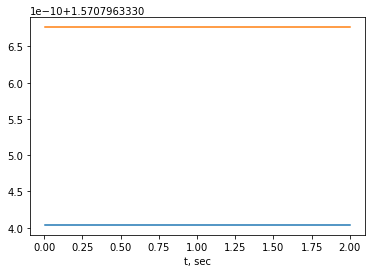

In [67]:
log_hover['propulsion/engine/pitch-angle-rad'].plot(label='Left')
log_hover['propulsion/engine[1]/pitch-angle-rad'].plot(label='Right')

In [68]:
#Autopilot hover
op_hover_auto = dict(op_hover)
op_hover_auto['ic/theta-deg'] = 0 #pitch offset initial condition
op_hover_auto['ic/phi-deg'] = 10 #roll offset initial condition
op_hover_auto['ic/h-agl-ft'] = 5000

op_hover_auto['ap/heading-cmd-deg'] = 280
op_hover_auto['ap/gear-enable'] = 1
op_hover_auto['ap/roll-enable'] = 1
op_hover_auto['ap/pitch-enable'] = 1
op_hover_auto['ap/yaw-enable'] = 1
op_hover_auto['ap/h-enable'] = 1
op_hover_auto['ap/h-sl-cmd-ft'] = 5000

In [69]:
log_hover_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_hover_auto,
    tf=20,
    realtime=False)

In [70]:
#Autopilot recovery (pitch)
op_hover_auto = dict(op_hover)
op_hover_auto['ic/theta-deg'] = -15
op_hover_auto['ic/phi-deg'] = 0
op_hover_auto['ic/h-agl-ft'] = 500

op_hover_auto['ap/heading-cmd-deg'] = 280
op_hover_auto['ap/gear-enable'] = 1
op_hover_auto['ap/roll-enable'] = 1
op_hover_auto['ap/pitch-enable'] = 1
op_hover_auto['ap/yaw-enable'] = 1
op_hover_auto['ap/h-enable'] = 1
op_hover_auto['ap/h-sl-cmd-ft'] = 980

log_hover_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_hover_auto,
    tf=10,
    realtime=True)

#Autopilot recovery (roll)
op_hover_auto = dict(op_hover)
op_hover_auto['ic/theta-deg'] = 0
op_hover_auto['ic/phi-deg'] = 10
op_hover_auto['ic/h-agl-ft'] = 500

op_hover_auto['ap/heading-cmd-deg'] = 280
op_hover_auto['ap/gear-enable'] = 1
op_hover_auto['ap/roll-enable'] = 1
op_hover_auto['ap/pitch-enable'] = 1
op_hover_auto['ap/yaw-enable'] = 1
op_hover_auto['ap/h-enable'] = 1
op_hover_auto['ap/h-sl-cmd-ft'] = 980

log_hover_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_hover_auto,
    tf=10,
    realtime=True)

#Autopilot recovery (combined)
op_hover_auto = dict(op_hover)
op_hover_auto['ic/theta-deg'] = -5
op_hover_auto['ic/phi-deg'] = 5
op_hover_auto['ic/h-agl-ft'] = 500

op_hover_auto['ap/heading-cmd-deg'] = 280
op_hover_auto['ap/gear-enable'] = 1
op_hover_auto['ap/roll-enable'] = 1
op_hover_auto['ap/pitch-enable'] = 1
op_hover_auto['ap/yaw-enable'] = 1
op_hover_auto['ap/h-enable'] = 1
op_hover_auto['ap/h-sl-cmd-ft'] = 980

log_hover_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_hover_auto,
    tf=20,
    realtime=False)

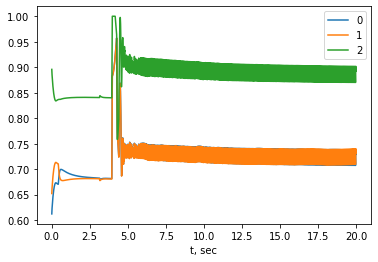

In [71]:
log_hover_auto['fcs/throttle-pos-norm'].plot(label='0')
log_hover_auto['fcs/throttle-pos-norm[1]'].plot(label='1')
log_hover_auto['fcs/throttle-pos-norm[2]'].plot(label='2')

plt.legend()

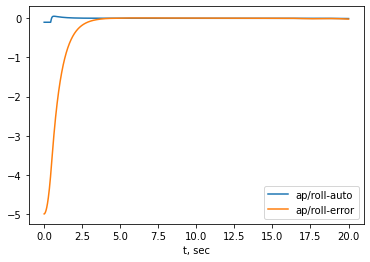

In [72]:
log_hover_auto['ap/roll-auto'].plot()
log_hover_auto['ap/roll-error'].plot()
plt.legend()


<AxesSubplot:xlabel='t, sec'>

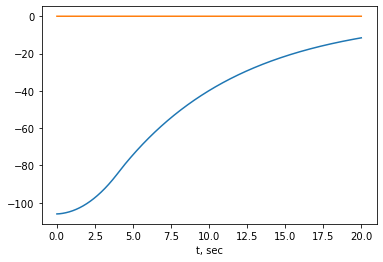

In [73]:
log_hover_auto['ap/h-error'].plot()
log_hover_auto['ic/vt-fps'].plot()

In [74]:
#props

## Transition

In [39]:
def trim_transition(vt_fps, gamma_deg, accel_g):
    print('trimming @ Vt=', vt_fps, 'fps', 'gamma = ', gamma_deg, 'deg')
    
    def accel_gamma(fdm, accel_g, gamma_deg):
        gamma = np.deg2rad(gamma_deg)
        g = 32.2
        theta = fdm['attitude/theta-rad']
        C_nb = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        a_n = accel_g*g*np.array([np.cos(gamma), np.sin(gamma)])
        a_b = C_nb.T.dot(a_n)
        return a_b
    
    if vt_fps < 200:
        x0 = [0.4, 0, 0, 0, np.deg2rad(70),np.deg2rad(70), np.deg2rad(0), 0],
    elif vt_fps < 400:
        x0 = [0.4, 0, 0, 0, np.deg2rad(15), np.deg2rad(15), np.deg2rad(0), 0],
    else:
        x0 = [0.4, 0, 0, 0, np.deg2rad(0), np.deg2rad(0), np.deg2rad(0), 0],

    op, props = trim(
        aircraft='BR1-mk3',
        ic={
            'ic/h-sl-ft': 800,
            'ic/vt-fps': vt_fps,
            'ic/gamma-deg': gamma_deg,
            'ap/gear-enable': 1,
        },
        design_vector=[
            'fcs/throttle-cmd-norm',
            'fcs/elevator-cmd-norm',
            'fcs/rudder-cmd-norm',
            'fcs/aileron-cmd-norm',
            'propulsion/engine/pitch-angle-rad',
            'propulsion/engine[1]/pitch-angle-rad',
            'ic/alpha-rad',
            'ic/beta-rad',
        ],
        x0=x0,
        verbose=False,
        method='SLSQP',
        eq_constraints= [
            lambda fdm: fdm['accelerations/udot-ft_sec2'] - accel_gamma(fdm, accel_g, gamma_deg)[0],
            lambda fdm: fdm['accelerations/vdot-ft_sec2'],
            lambda fdm: fdm['accelerations/wdot-ft_sec2'] - accel_gamma(fdm, accel_g, gamma_deg)[1],
            lambda fdm: fdm['accelerations/pdot-rad_sec2'],
            lambda fdm: fdm['accelerations/qdot-rad_sec2'],
            lambda fdm: fdm['accelerations/rdot-rad_sec2'],
        ],
        cost=lambda fdm: fdm['fcs/throttle-cmd-norm'],
        bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1],
                [np.deg2rad(0), np.deg2rad(120)],[np.deg2rad(0), np.deg2rad(120)],
                [-0.1, 0.1], [-0.1, 0.1]],
        tol=1e-12)
    return op

ops_trim = [trim_transition(vt_fps=vt, gamma_deg=0, accel_g=0)
                  for vt in [80, 100, 150, 200, 250, 300, 400, 500, 600]]
for op in ops_trim:
    print('\nvt fps', op['ic/vt-fps'])
    print('theta deg', op['ic/gamma-deg'] + np.rad2deg(op['ic/alpha-rad']))
    print('elevator', op['fcs/elevator-cmd-norm'])
    print('bucket', np.rad2deg(op['propulsion/engine/pitch-angle-rad']))
    print('throttle', op['fcs/throttle-cmd-norm'])

trimming @ Vt= 80 fps gamma =  0 deg
trimming @ Vt= 100 fps gamma =  0 deg
trimming @ Vt= 150 fps gamma =  0 deg
trimming @ Vt= 200 fps gamma =  0 deg
trimming @ Vt= 250 fps gamma =  0 deg
trimming @ Vt= 300 fps gamma =  0 deg
trimming @ Vt= 400 fps gamma =  0 deg
trimming @ Vt= 500 fps gamma =  0 deg
trimming @ Vt= 600 fps gamma =  0 deg

vt fps 80
theta deg 5.729577951308227
elevator 0.34439175711854986
bucket 81.86131896159377
throttle 0.7682046082373979

vt fps 100
theta deg 5.729577951308233
elevator 0.3296099131124077
bucket 81.46276333726799
throttle 0.7523580845155627

vt fps 150
theta deg 5.729577951308233
elevator 0.3119774340152108
bucket 79.80680333058322
throttle 0.6892830390794921

vt fps 200
theta deg 5.729577951308233
elevator 0.2028108226462416
bucket 76.40900622747449
throttle 0.5857380271987704

vt fps 250
theta deg 5.72957795130822
elevator 0.08818417585587802
bucket 66.56038110018754
throttle 0.4250890760551771

vt fps 300
theta deg 5.673753227654226
elevator -3.30

In [40]:
log_transition = []
for op in ops_trim:
    log = simulate(
        aircraft='BR1-mk3',
        op_0=op,
        tf=10,
        realtime=True)
    log_transition.append(log)

KeyboardInterrupt: 

In [120]:
ops_transition = [trim_transition(vt_fps=vt, gamma_deg=10, accel_g=0.3)
                  for vt in [10, 50, 100, 150, 200, 250, 300, 400, 500, 600]]

ops_transition_auto = []
for op in ops_transition:
    op = dict(op)
    print('\nvt fps', op['ic/vt-fps'])
    print('theta deg', op['ic/gamma-deg'] + np.rad2deg(op['ic/alpha-rad']))
    print('elevator', op['fcs/elevator-cmd-norm'])
    print('bucket', np.rad2deg(op['propulsion/engine/pitch-angle-rad']))
    print('throttle', op['fcs/throttle-cmd-norm'])
    op['ap/roll-enable'] = 1
    op['ap/pitch-enable'] = 1
    op['ap/yaw-enable'] = 1
    op['ap/h-enable'] = 1
    op['ap/h-sl-cmd-ft'] = 5000
    ops_transition_auto.append(op)

trimming @ Vt= 10 fps gamma =  10 deg
trimming @ Vt= 50 fps gamma =  10 deg
trimming @ Vt= 100 fps gamma =  10 deg
trimming @ Vt= 150 fps gamma =  10 deg
trimming @ Vt= 200 fps gamma =  10 deg
trimming @ Vt= 250 fps gamma =  10 deg
trimming @ Vt= 300 fps gamma =  10 deg
trimming @ Vt= 400 fps gamma =  10 deg
trimming @ Vt= 500 fps gamma =  10 deg
trimming @ Vt= 600 fps gamma =  10 deg

vt fps 10
theta deg 4.270422048691768
elevator 0.14470551040662788
bucket 63.65882282308838
throttle 0.7866163833663141

vt fps 50
theta deg 4.270422048691767
elevator 0.14862783118739922
bucket 64.04643527811915
throttle 0.7981587137432959

vt fps 100
theta deg 15.729577951308233
elevator -0.10301300545714691
bucket 50.75976609882462
throttle 0.7777243019539114

vt fps 150
theta deg 15.729577951308228
elevator -0.2054727186613217
bucket 45.19601892359664
throttle 0.7305437740326273

vt fps 200
theta deg 15.729577951308233
elevator -0.32822633015796165
bucket 32.80456282288677
throttle 0.6705484071092481

In [ ]:
log_transition_auto = []
for op in ops_transition_auto:
    log = simulate(
        aircraft='BR1-mk3',
        op_0=op,
        tf=20,
        realtime=True)
    log_transition_auto.append(log)


Text(0, 0.5, 'Normalized Command of Flight Surfaces')

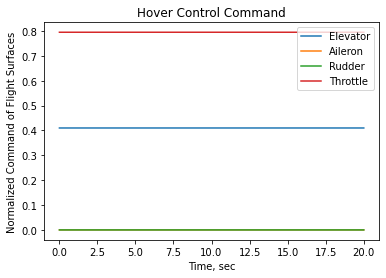

In [84]:
log_hover_auto['fcs/elevator-cmd-norm'].plot(label='Elevator')
log_hover_auto['fcs/aileron-cmd-norm'].plot(label='Aileron')
log_hover_auto['fcs/rudder-cmd-norm'].plot(label='Rudder')
log_hover_auto['fcs/throttle-cmd-norm'].plot(label='Throttle')

plt.legend()
plt.title('Hover Control Command',)
plt.xlabel('Time, sec')
plt.ylabel('Normalized Command of Flight Surfaces')


## Cruise Trim

In [85]:
op_cruise, props = trim(
    aircraft='BR1-mk3',
    ic={
        'ic/gamma-deg': 0,
        'ic/vt-fps': 787.73, #Mach 0.7 = 787.73 ft/s
        'ic/h-sl-ft': 5000,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        'propulsion/engine/pitch-angle-rad': 0,
        'propulsion/engine[1]/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
    ],
    method='SLSQP',
    eq_constraints= [
        lambda fdm: fdm['accelerations/udot-ft_sec2'],
        lambda fdm: fdm['accelerations/vdot-ft_sec2'],
        lambda fdm: fdm['accelerations/wdot-ft_sec2'],
        lambda fdm: fdm['accelerations/pdot-rad_sec2'],
        lambda fdm: fdm['accelerations/qdot-rad_sec2'],
        lambda fdm: fdm['accelerations/rdot-rad_sec2'],
    ],
    cost=lambda fdm: fdm['fcs/throttle-cmd-norm'],
    x0=[0.2, 0, 0, 0, 0, 0],
    verbose=False,
    bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]],
    tol=1e-3
)
op_cruise

{'ic/gamma-deg': 0,
 'ic/vt-fps': 787.73,
 'ic/h-sl-ft': 5000,
 'gear/gear-cmd-norm': 0,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'propulsion/engine/pitch-angle-rad': 0,
 'propulsion/engine[1]/pitch-angle-rad': 0,
 'fcs/throttle-cmd-norm': 0.5307975329945991,
 'fcs/elevator-cmd-norm': -0.025786764569980414,
 'fcs/rudder-cmd-norm': 0.00022470806563411214,
 'fcs/aileron-cmd-norm': 0.00017128133403449073,
 'ic/alpha-rad': -0.0032898215234572403,
 'ic/beta-rad': 0.00016341232456333016}

In [45]:
log_cruise = simulate(
    aircraft='BR1-mk3',
    op_0=op_cruise,
    tf=15,
    realtime=True)

Text(0, 0.5, 'Normalized Command of Flight Surfaces')

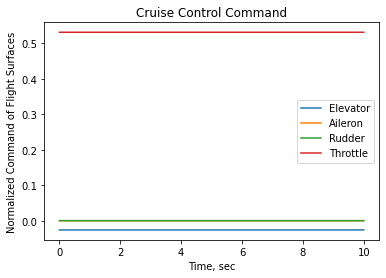

In [86]:
log_cruise_auto['fcs/elevator-cmd-norm'].plot(label='Elevator')
log_cruise_auto['fcs/aileron-cmd-norm'].plot(label='Aileron')
log_cruise_auto['fcs/rudder-cmd-norm'].plot(label='Rudder')
log_cruise_auto['fcs/throttle-cmd-norm'].plot(label='Throttle')

plt.legend()
plt.title('Cruise Control Command',)
plt.xlabel('Time, sec')
plt.ylabel('Normalized Command of Flight Surfaces')

In [127]:
#log_cruise 

In [59]:
#Heading Change 
op_cruise_auto = dict(op_cruise)
op_cruise_auto['ic/vt-fps'] = 787.73
op_cruise_auto['ic/theta-deg'] = 0
op_cruise_auto['ic/phi-deg'] = 0
op_cruise_auto['ap/roll-enable'] = 1
op_cruise_auto['ap/pitch-enable'] = 1
op_cruise_auto['ap/yaw-enable'] = 1
op_cruise_auto['ap/h-enable'] = 1
op_cruise_auto['ap/heading-cmd-deg'] = 300
op_cruise_auto['ap/h-sl-cmd-ft'] = 10000

log_cruise_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_cruise_auto,
    tf=25,
    realtime=True)

op_cruise_auto = dict(op_cruise)
op_cruise_auto['ic/vt-fps'] = 807.73
op_cruise_auto['ap/v-cmd-fps'] = 20000
op_cruise_auto['ic/theta-deg'] = 0
op_cruise_auto['ic/phi-deg'] = 0
op_cruise_auto['ap/roll-enable'] = 1
op_cruise_auto['ap/pitch-enable'] = 1
op_cruise_auto['ap/yaw-enable'] = 1
op_cruise_auto['ap/h-enable'] = 1
op_cruise_auto['ap/heading-cmd-deg'] = 280
op_cruise_auto['ap/h-sl-cmd-ft'] = 10000

log_cruise_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_cruise_auto,
    tf=10,
    realtime=True)

op_cruise_auto = dict(op_cruise)
op_cruise_auto['ic/vt-fps'] = 787.73
op_cruise_auto['ic/theta-deg'] = 0
op_cruise_auto['ic/phi-deg'] = 0
op_cruise_auto['ap/roll-enable'] = 1
op_cruise_auto['ap/pitch-enable'] = 1
op_cruise_auto['ap/yaw-enable'] = 1
op_cruise_auto['ap/h-enable'] = 1
op_cruise_auto['ap/heading-cmd-deg'] = 280
op_cruise_auto['ap/h-sl-cmd-ft'] = 10100

log_cruise_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_cruise_auto,
    tf=10,
    realtime=True)


In [ ]:
op_cruise_auto = dict(op_cruise)
op_cruise_auto['ic/vt-fps'] = 787.73
op_cruise_auto['ap/v-cmd-fps'] = 20000
op_cruise_auto['ic/theta-deg'] = 0
op_cruise_auto['ic/phi-deg'] = 0
op_cruise_auto['ap/roll-enable'] = 1
op_cruise_auto['ap/pitch-enable'] = 1
op_cruise_auto['ap/yaw-enable'] = 1
op_cruise_auto['ap/h-enable'] = 1
op_cruise_auto['ap/heading-cmd-deg'] = 280
op_cruise_auto['ap/h-sl-cmd-ft'] = 10000

log_cruise_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_cruise_auto,
    tf=30,
    realtime=True)

<AxesSubplot:xlabel='t, sec'>

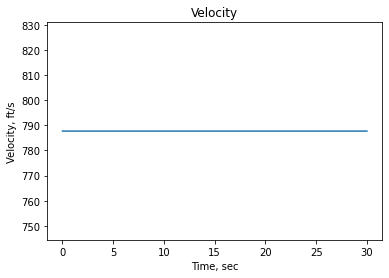

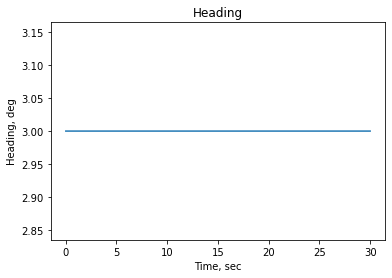

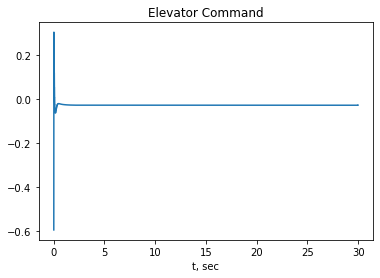

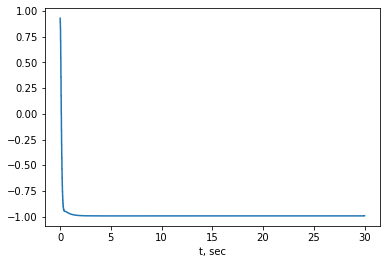

In [124]:
plt.figure()
log_cruise_auto['ic/vt-fps'].plot()
plt.title("Velocity")
plt.xlabel("Time, sec")
plt.ylabel("Velocity, ft/s")

plt.figure()
log_cruise_auto['ap/heading-error-to-phi-deg-cmd'].plot()
plt.title("Heading")
plt.xlabel("Time, sec")
plt.ylabel("Heading, deg")

plt.figure()
log_cruise_auto['ap/elevator-cmd-norm'].plot()
plt.title("Elevator Command")

plt.figure()
log_cruise_auto['ap/pitch-error'].plot()


In [43]:
#props

## Auto Takeoff

In [60]:
log_takeoff_auto = simulate(
    aircraft='BR1-mk3',
    op_0=op_ground,
    op_list=[('hover', op_hover_auto, lambda fdm: fdm.get_sim_time() > 1),
             ('10 fps', ops_transition_auto[0], lambda fdm: fdm.get_sim_time() > 10),
             ('50 fps', ops_transition_auto[1], lambda fdm: fdm['velocities/vt-fps'] > 50),
             ('100 fps', ops_transition_auto[2], lambda fdm: fdm['velocities/vt-fps'] > 100),
             ('150 fps', ops_transition_auto[3], lambda fdm: fdm['velocities/vt-fps'] > 150),
             ('200 fps', ops_transition_auto[4], lambda fdm: fdm['velocities/vt-fps'] > 200),
             ('250 fps', ops_transition_auto[5], lambda fdm: fdm['velocities/vt-fps'] > 250),
             ('300 fps', ops_transition_auto[6], lambda fdm: fdm['velocities/vt-fps'] > 300),
             ('400 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 400),
             ('500 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 500),
             ('600 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 600),
    ],
    tf=60,
    realtime=True, verbose=True)

NameError: name 'op_ground' is not defined

## Hover Control Design

In [29]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/q-rad_sec'],#state: pitch rate
    states_deriv = ['accelerations/qdot-rad_sec2'],
    inputs=['fcs/elevator-cmd-norm'],
    outputs=['ic/q-rad_sec'],
    ic=op_hover, #linearize about this condition
    dx=1e-3,     #finite difference with this step
    n_round=3    #dump decimals past this place
))
s = control.tf([1, 0], [1])
rad2deg = 180/np.pi
G_elev_to_pitch = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_elev_to_pitch

0 states have been removed from the model


TransferFunction(array([95.11099399]), array([1., 0., 0.]))

In [17]:
sys

StateSpace(array([[-0.]]), array([[1.66]]), array([[1.]]), array([[0.]]))

(inf, 159.5529603064055, nan, 3.4266721361636594)

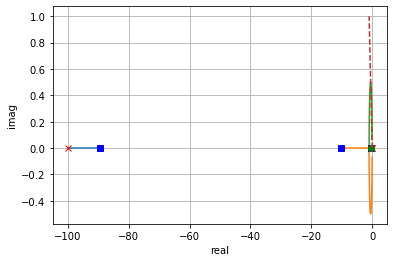

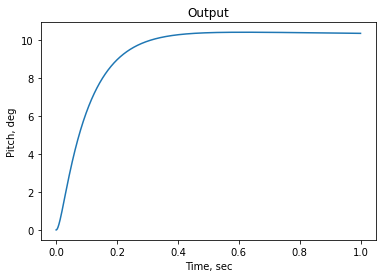

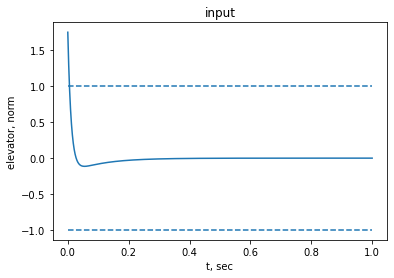

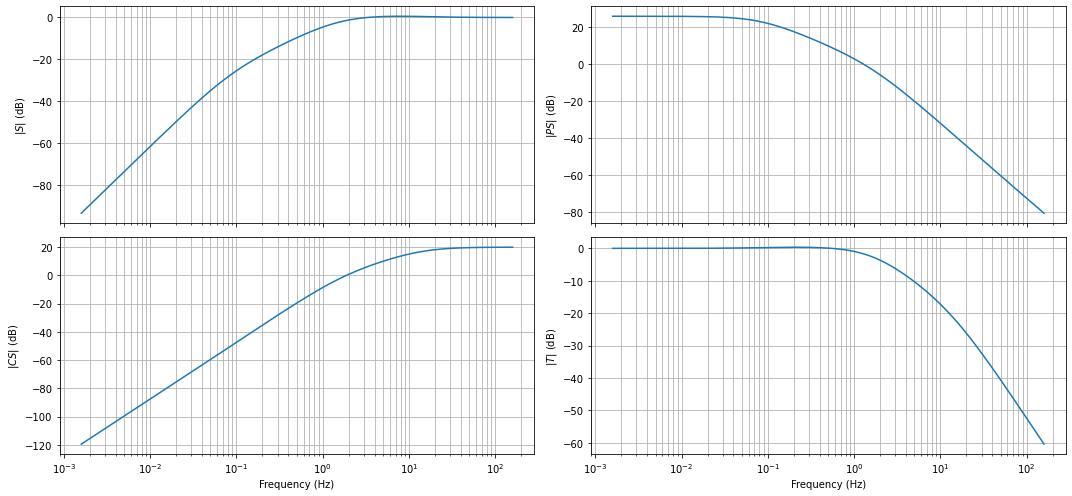

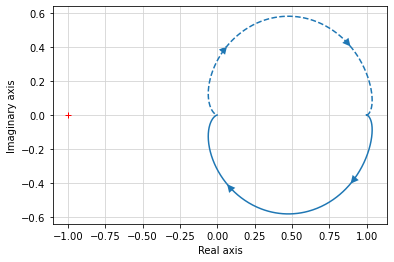

In [27]:
H_elev_to_pitch = 0.05*(s/0.5*(100/(s+100))+1) #This is the controller, (100/(s+100)) is low bypass filter

H_elev_to_pitch

plt.figure()
rootlocus(G_elev_to_pitch*H_elev_to_pitch)
plt.plot([0, -1], [0, 1], '--')

Gc_elev_to_pitch = G_elev_to_pitch*H_elev_to_pitch/(1 + G_elev_to_pitch*H_elev_to_pitch)

Gc_elev_to_pitch

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_elev_to_pitch, T=np.linspace(0, 1, 1000));
plt.plot(t, y)
plt.ylabel('Pitch, deg')
plt.xlabel('Time, sec')
plt.title('Output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, = control.forced_response(H_elev_to_pitch, T=t, U=e)
plt.plot(t, u)
plt.hlines([-1, 1], t[0], t[-1], linestyles='dashed')
plt.title('input')
plt.ylabel('elevator, norm')
plt.xlabel('t, sec')

plt.figure(figsize=(15, 7))
control.gangof4(G_elev_to_pitch, H_elev_to_pitch, Hz=True, dB=True)

plt.figure()
control.nyquist(Gc_elev_to_pitch, omega=np.logspace(-3, 3, 1000));

control.margin(Gc_elev_to_pitch) 

In [28]:
H_elev_to_pitch

TransferFunction(array([5.025, 2.5  ]), array([ 0.5, 50. ]))

In [20]:
Gc_elev_to_pitch

TransferFunction(array([  238.9663724 , 24015.52598291, 11888.87424896,     0.        ,
           0.        ]), array([2.50000000e-01, 5.00000000e+01, 2.73896637e+03, 2.40155260e+04,
       1.18888742e+04, 0.00000000e+00, 0.00000000e+00]))

## Roll

In [24]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/p-rad_sec'],
    states_deriv = ['accelerations/pdot-rad_sec2'],
    inputs=['fcs/aileron-cmd-norm'],
    outputs=['ic/p-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
rad2deg = 180/np.pi
s = control.tf([1, 0], [1])
G_aileron_to_roll = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_aileron_to_roll

0 states have been removed from the model


TransferFunction(array([110.98192492]), array([1., 0., 0.]))

G = kp + kd* s *N/(s+N)

In [41]:
kp = 0.199702605044223
kd = 0.0871332100527688

N = 253.629592864545

H_aileron_to_roll = kp + kd * s * N/(s+N)
H_aileron_to_roll

TransferFunction(array([22.2992632 , 50.65049041]), array([  1.        , 253.62959286]))

In [38]:
H_aileron_to_roll2 = 0.1*( s/0.5* (100/(s+100)) + 1)
H_aileron_to_roll2

TransferFunction(array([10.05,  5.  ]), array([ 0.5, 50. ]))

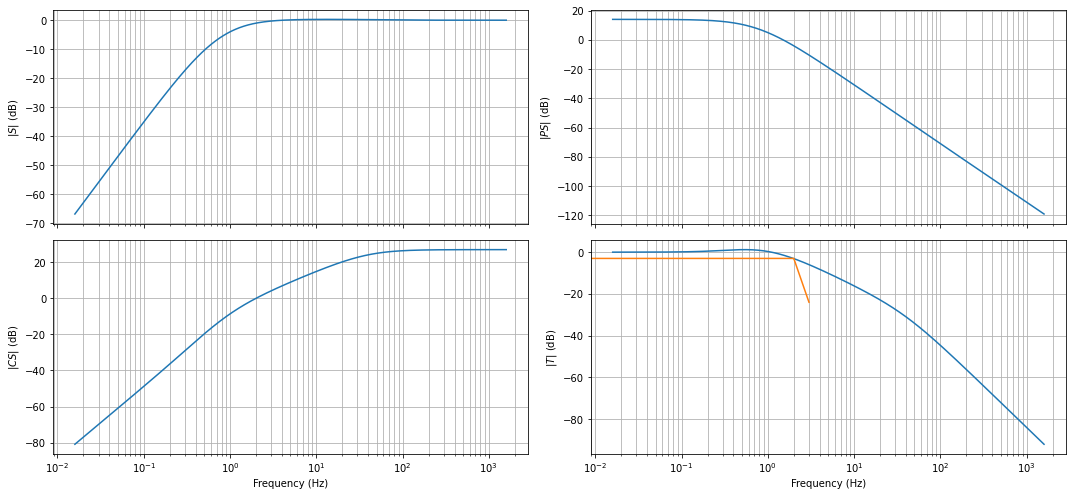

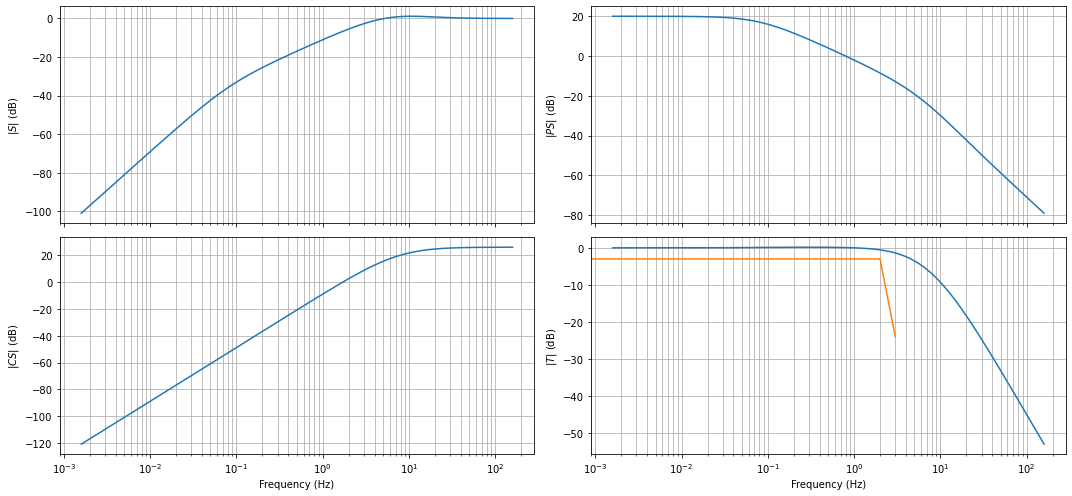

In [48]:
plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll, Hz=True, dB=True)
plt.plot([-3,-3,-3,-3 -3 -3 -3 -3 -3 -3 -3])

plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll2, Hz=True, dB=True)
plt.plot([-3,-3,-3,-3 -3 -3 -3 -3 -3 -3 -3])

# Plotting:

(inf, 140.5618465339736, nan, 6.926972832720798)

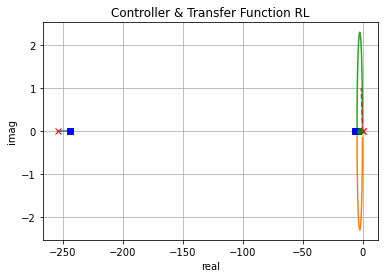

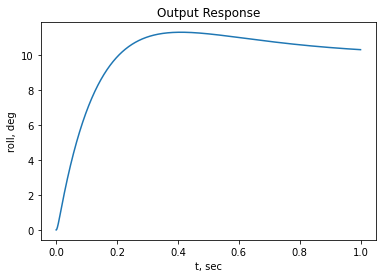

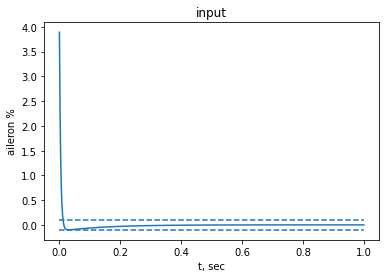

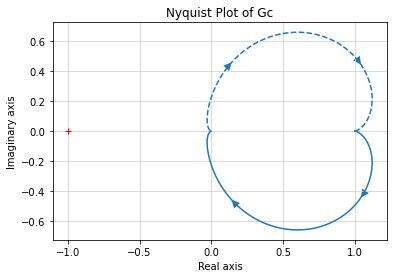

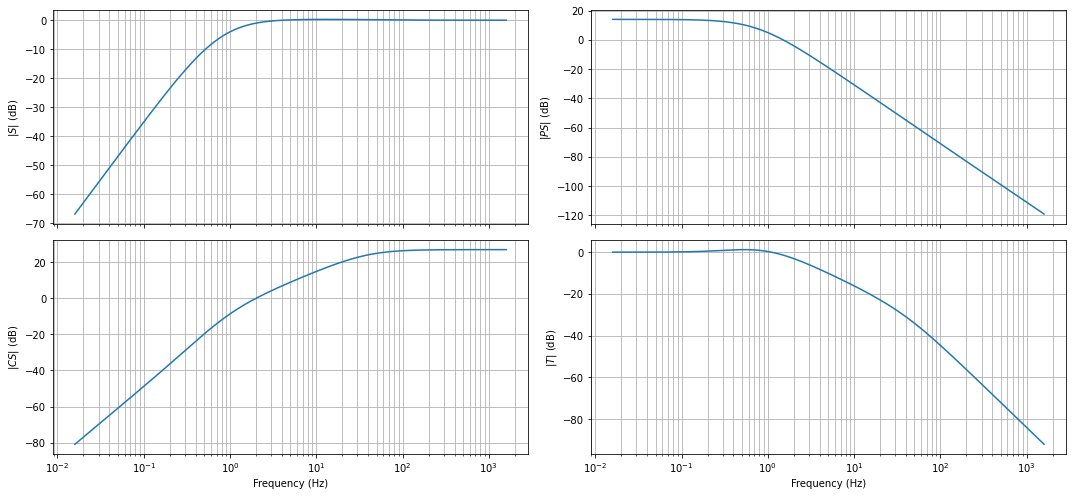

In [133]:
#H_aileron_to_roll = 0.1*( s/0.5* (100/(s+100)) + 1)

plt.figure()
rootlocus(G_aileron_to_roll*H_aileron_to_roll)
plt.plot([0, -1], [0, 1], '--')
plt.title('Controller & Transfer Function RL')
Gc_aileron_to_roll  = G_aileron_to_roll*H_aileron_to_roll/(1 + G_aileron_to_roll*H_aileron_to_roll)


plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_aileron_to_roll, T=np.linspace(0, 1, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('roll, deg')
plt.title('Output Response')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u,= control.forced_response(H_aileron_to_roll, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('aileron %')
plt.title('input')

plt.figure()
control.nyquist(Gc_aileron_to_roll, omega=np.logspace(-3, 3, 1000));
plt.title("Nyquist Plot of Gc")

plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll, Hz=True, dB=True)

control.margin(Gc_aileron_to_roll)

## Yaw

In [59]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/r-rad_sec'],
    states_deriv = ['accelerations/rdot-rad_sec2'],
    inputs=['propulsion/engine/yaw-angle-rad'],
    outputs=['ic/r-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
G_rudder_to_yaw = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_rudder_to_yaw

0 states have been removed from the model


TransferFunction(array([0.]), array([1.]))

Yaw angle seems to have no impact on r moment, need to investigate. Can add another lift-fan to model this if necessary.

## Altitude

In [60]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/w-fps'],
    states_deriv = ['accelerations/wdot-ft_sec2'],
    inputs=['fcs/throttle-cmd-norm'],
    outputs=['ic/w-fps'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
G_throttle_to_alt = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_throttle_to_alt

0 states have been removed from the model


TransferFunction(array([78.562]), array([1., 0., 0.]))

(inf, 127.77841379656866, nan, 1.5060585626835299)

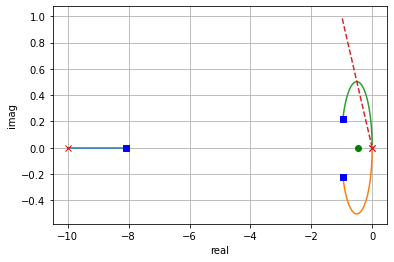

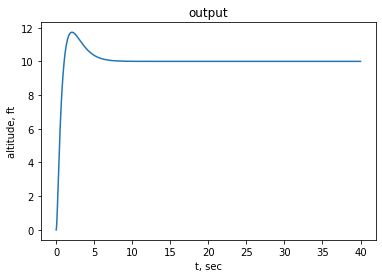

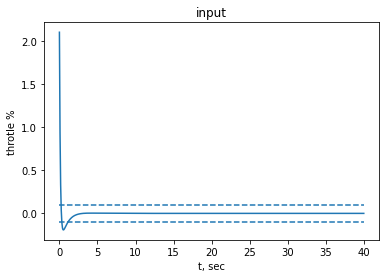

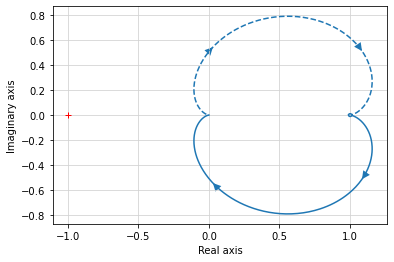

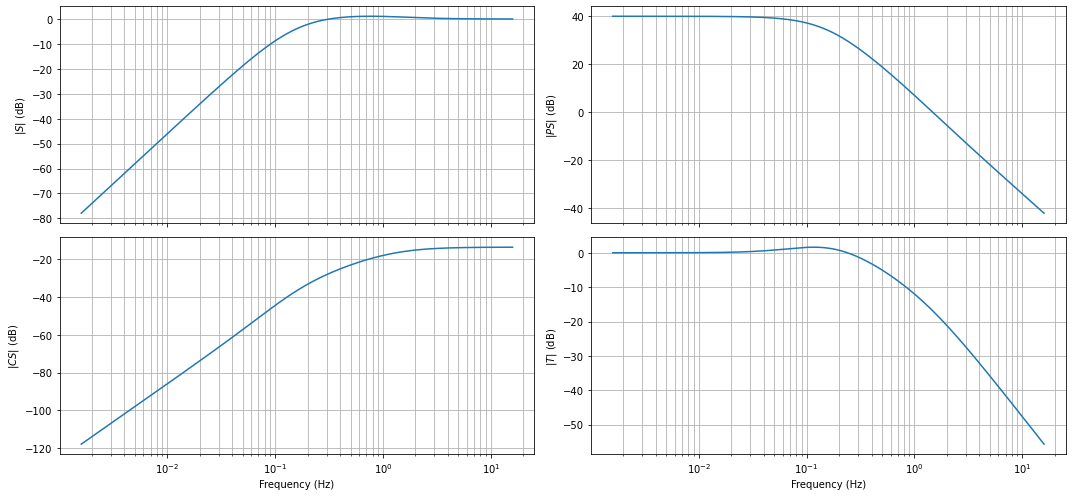

In [61]:
H_throttle_to_alt = 0.01*(2*s*(10/(s+10)) + 1)


plt.figure()
rootlocus(G_throttle_to_alt*H_throttle_to_alt)
plt.plot([0, -1], [0, 1], '--')

Gc_throttle_to_alt = G_throttle_to_alt*H_throttle_to_alt/(1 + G_throttle_to_alt*H_throttle_to_alt)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_throttle_to_alt, T=np.linspace(0, 40, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('altitude, ft')
plt.title('output')

plt.figure()
# error computed in ft
e = step_size-y
t, u, = control.forced_response(H_throttle_to_alt, T=t, U=e) #deleted "_"
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('throtle %')
plt.title('input')

plt.figure()
control.nyquist(Gc_throttle_to_alt, omega=np.logspace(-3, 3, 1000));

plt.figure(figsize=(15, 7))
control.gangof4(G_throttle_to_alt, H_throttle_to_alt, Hz=True, dB=True)

control.margin(Gc_throttle_to_alt)

In [62]:
H_throttle_to_alt

TransferFunction(array([0.21, 0.1 ]), array([ 1, 10]))

In [63]:
Gc_throttle_to_alt

TransferFunction(array([ 16.49802, 172.8364 ,  78.562  ,   0.     ,   0.     ]), array([  1.     ,  20.     , 116.49802, 172.8364 ,  78.562  ,   0.     ,
         0.     ]))

## Cruise Control Design

Pitch

In [135]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/q-rad_sec'],#state: pitch rate
    states_deriv = ['accelerations/qdot-rad_sec2'],
    inputs=['fcs/elevator-cmd-norm'],
    outputs=['ic/q-rad_sec'],
    ic=op_cruise,#linearize about this condition
    dx=1e-3,     #finite difference with this step
    n_round=3    #dump decimals past this place
))
s = control.tf([1, 0], [1])
rad2deg = 180/np.pi
G_elev_to_pitch = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_elev_to_pitch

0 states have been removed from the model


TransferFunction(array([874.21900381]), array([1.   , 0.361, 0.   ]))

In [138]:
kp = 0.0109190374975713
kd = 0.00739347226358193
N = 734.701366789842

H_elev_to_pitch = kp + kd * s * N/(s+N)
H_elev_to_pitch

TransferFunction(array([5.44291321, 8.02223177]), array([  1.        , 734.70136679]))

(inf, 147.96557977471218, nan, 3.8145005809470374)

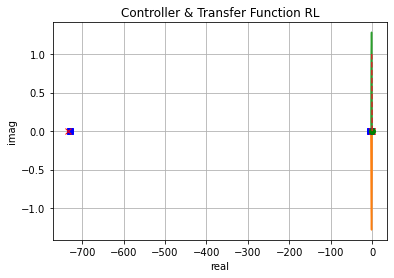

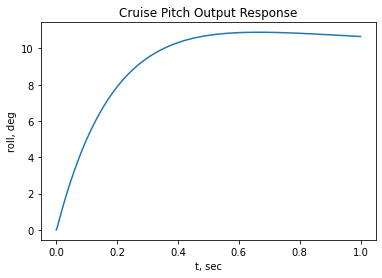

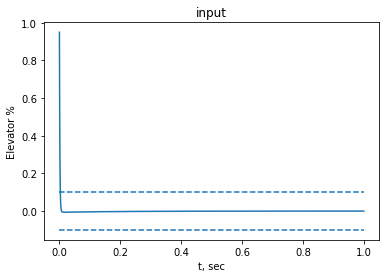

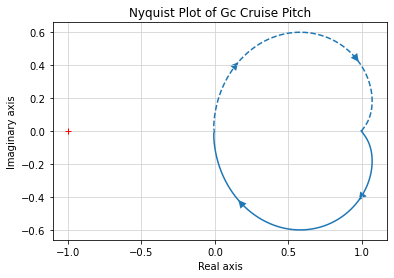

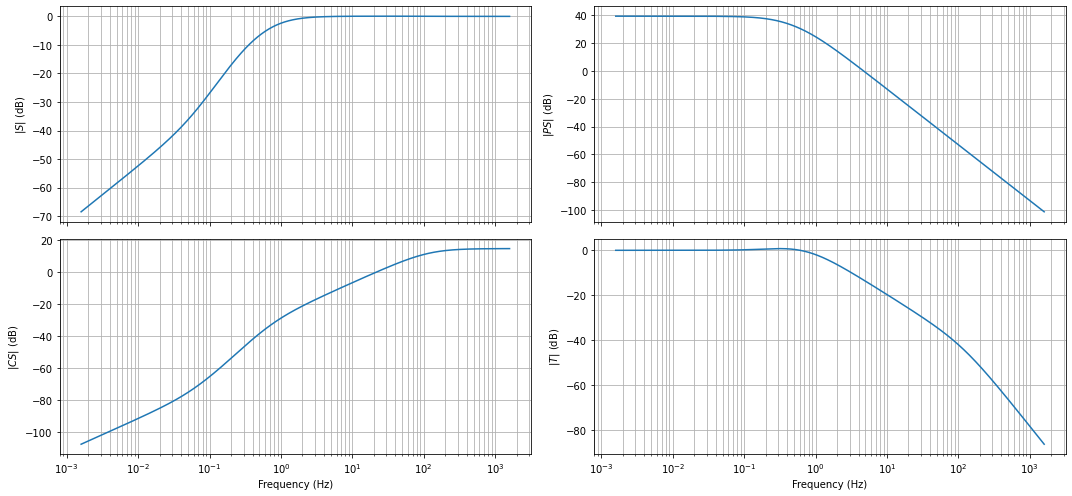

In [140]:
plt.figure()
rootlocus(G_elev_to_pitch*H_elev_to_pitch)
plt.plot([0, -1], [0, 1], '--')
plt.title('Controller & Transfer Function RL')
Gc_elev_to_pitch  = G_elev_to_pitch*H_elev_to_pitch/(1 + G_elev_to_pitch*H_elev_to_pitch)


plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_elev_to_pitch, T=np.linspace(0, 1, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('roll, deg')
plt.title('Cruise Pitch Output Response')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u,= control.forced_response(H_elev_to_pitch, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('Elevator %')
plt.title('input')

plt.figure()
control.nyquist(Gc_elev_to_pitch, omega=np.logspace(-3, 3, 1000));
plt.title("Nyquist Plot of Gc Cruise Pitch")

plt.figure(figsize=(15, 7))
control.gangof4(G_elev_to_pitch, H_elev_to_pitch, Hz=True, dB=True)

control.margin(Gc_elev_to_pitch)

Heading

In [141]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/p-rad_sec'],
    states_deriv = ['accelerations/pdot-rad_sec2'],
    inputs=['fcs/aileron-cmd-norm'],
    outputs=['ic/p-rad_sec'],
    ic=op_cruise,
    dx=1e-3,
    n_round=3
))
rad2deg = 180/np.pi
s = control.tf([1, 0], [1])
G_aileron_to_roll = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_aileron_to_roll

0 states have been removed from the model


TransferFunction(array([3294.27813888]), array([1., 0., 0.]))

In [144]:
kp = 0.00636403019951673
kd = 0.00296291854941035

N = 1142.8279760416

H_aileron_to_roll = kp + kd * s * N/(s+N)
H_aileron_to_roll

TransferFunction(array([3.39247024, 7.27299175]), array([1.00000000e+00, 1.14282798e+03]))

(inf, 143.00105235890106, nan, 6.531341544734874)

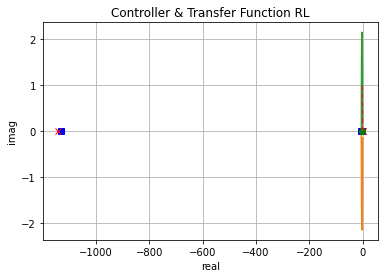

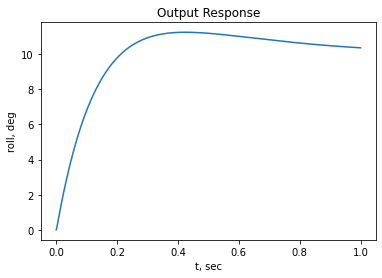

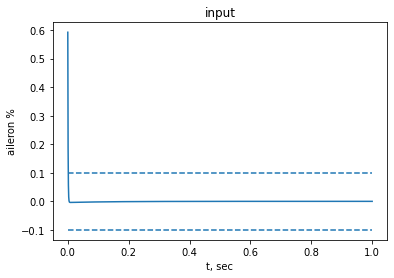

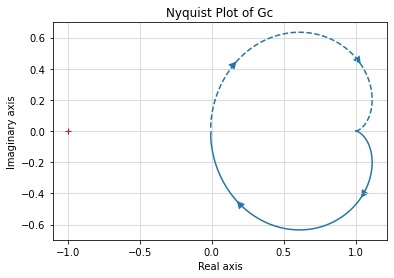

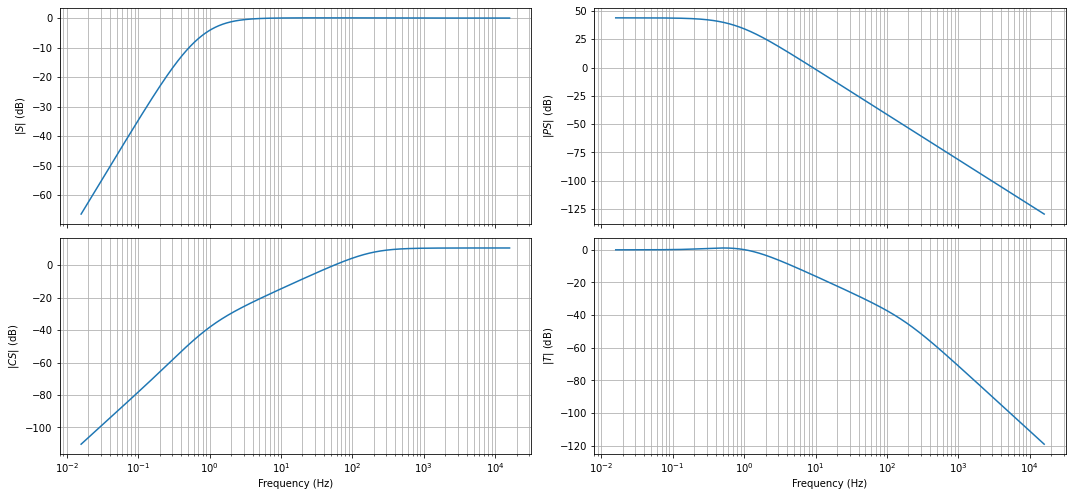

In [145]:
plt.figure()
rootlocus(G_aileron_to_roll*H_aileron_to_roll)
plt.plot([0, -1], [0, 1], '--')
plt.title('Controller & Transfer Function RL')
Gc_aileron_to_roll  = G_aileron_to_roll*H_aileron_to_roll/(1 + G_aileron_to_roll*H_aileron_to_roll)


plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_aileron_to_roll, T=np.linspace(0, 1, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('roll, deg')
plt.title('Output Response')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u,= control.forced_response(H_aileron_to_roll, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('aileron %')
plt.title('input')

plt.figure()
control.nyquist(Gc_aileron_to_roll, omega=np.logspace(-3, 3, 1000));
plt.title("Nyquist Plot of Gc")

plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll, Hz=True, dB=True)

control.margin(Gc_aileron_to_roll)

Altitude

In [75]:
sys = control.ss(*linearize(
    aircraft='BR1-mk3',
    states=['ic/w-fps'],
    states_deriv = ['accelerations/wdot-ft_sec2'],
    inputs=['fcs/throttle-cmd-norm'],
    outputs=['ic/w-fps'],
    ic=op_cruise,
    dx=1e-3,
    n_round=3
))
G_throttle_to_alt = clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_throttle_to_alt

0 states have been removed from the model


TransferFunction(array([0.002]), array([1.  , 1.63, 0.  ]))

In [151]:
kp = -106443.086619379
kd = -13921.6386000642

N = 661.063489753982

H_throttle_to_alt = kp + kd * s * N/(s+N)
H_throttle_to_alt

TransferFunction(array([ -9309530.08267156, -70365638.30079207]), array([  1.        , 661.06348975]))

(inf, 143.1990524829239, nan, 19.051832400998777)

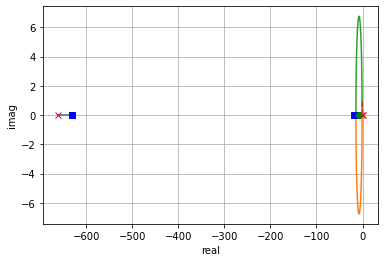

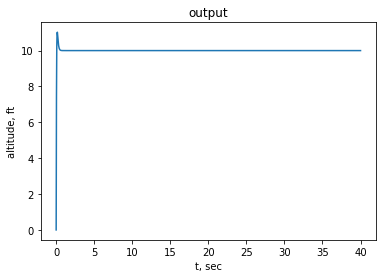

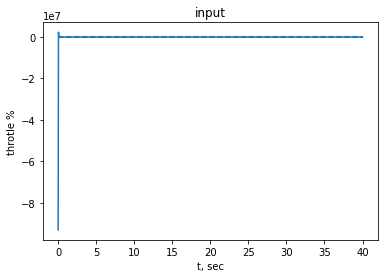

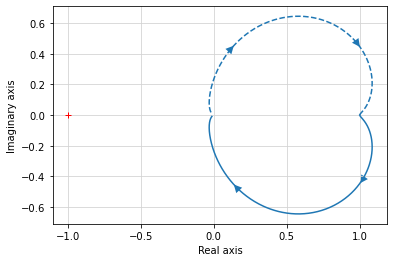

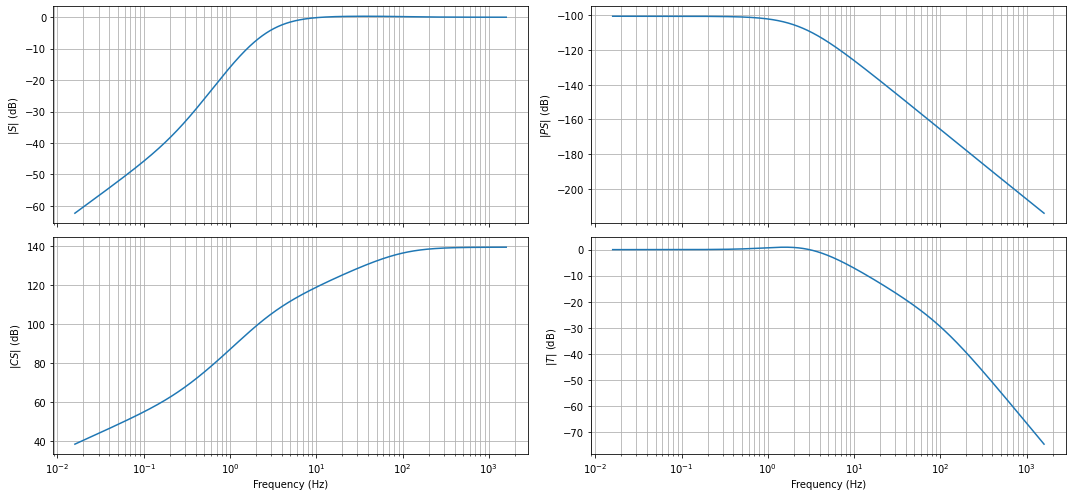

In [152]:
plt.figure()
rootlocus(G_throttle_to_alt*H_throttle_to_alt)
plt.plot([0, -1], [0, 1], '--')

Gc_throttle_to_alt = G_throttle_to_alt*H_throttle_to_alt/(1 + G_throttle_to_alt*H_throttle_to_alt)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_throttle_to_alt, T=np.linspace(0, 40, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('altitude, ft')
plt.title('output')

plt.figure()
# error computed in ft
e = step_size-y
t, u, = control.forced_response(H_throttle_to_alt, T=t, U=e) #deleted "_"
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('throtle %')
plt.title('input')

plt.figure()
control.nyquist(Gc_throttle_to_alt, omega=np.logspace(-3, 3, 1000));

plt.figure(figsize=(15, 7))
control.gangof4(G_throttle_to_alt, H_throttle_to_alt, Hz=True, dB=True)

control.margin(Gc_throttle_to_alt)